In [ ]:
import sys
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

sys.path.insert(0, '/Users/diol5851/Documents/rental-housing-cost/')
from notebooks.data_cleaning_EDA.AHS_Parser import AHS_Parser
sys.path.remove('/Users/diol5851/Documents/rental-housing-cost/')

In [2]:
def get_dataset(year):
    raw_dat = pd.read_feather(f'../../data/AHS_{year}.feather')
    # Drop the year column, since that does not add information here.
    dat = raw_dat.drop(columns=['YEAR'])
    # Move ADEQUACY to the first column.
    adequacy = dat.pop('ADEQUACY')
    dat.insert(0, 'ADEQUACY', adequacy)
    # Drop apartments with four or more bathrooms.
    dat = dat[dat['BATHROOMS'] < 4]
    # Remap the ADEQUACY column to a binary column, where 1 is adequate.
    ad_default = defaultdict(lambda: 0)
    ad_default['Adequate'] = 1
    dat['ADEQUACY'] = dat['ADEQUACY'].map(ad_default)
    # Dropping columns that seem redundant for prediction.
    dat = dat.drop(columns = [
        'UTILAMT', 'HOAAMT', 'INSURAMT', 'FINCP', 'KITCHENS', 'DINING', 'LAUNDY', 'GARAGE', 'PORCH',
        'NUMNONREL', 'HHADLTKIDS', 'SUBDIV'
        ])
    # Parse the remaining categorical columns.
    parser = AHS_Parser()
    for col in dat.select_dtypes(include=['object']).columns:
        dat[col] = dat[col].astype('category')
        dat[col] = dat[col].cat.rename_categories(parser.parse_categorical(col, year))
        if 'Not reported' in dat[col].cat.categories:
            dat[col] = dat[col].cat.remove_categories(['Not reported'])
    # Drop columns with less than 20k non-null values.
    dat = dat.drop(columns = dat.columns[dat.count() < 20e3])
    # Drop all remaining null values.
    dat = dat.dropna()
    return dat

In [3]:
# Pull the 2023 AHS data.
dat = get_dataset(2023)
dat.columns

Index(['ADEQUACY', 'OMB13CBSA', 'BLD', 'STORIES', 'YRBUILT', 'RENT', 'RENTSUB',
       'TOTHCAMT', 'UNITFLOORS', 'BATHROOMS', 'BEDROOMS', 'TOTROOMS',
       'ACPRIMARY', 'HEATTYPE', 'HOTWATER', 'SEWTYPE', 'WATSOURCE', 'COOKTYPE',
       'DRYER', 'ROACH', 'RODENT', 'SEWBREAK', 'HINCP', 'NUMPEOPLE', 'HHAGE',
       'HHCITSHP', 'HHGRAD', 'HHMAR', 'HHMOVE', 'HHNATVTY', 'HHRACE',
       'NEARABAND', 'NEARBARCL', 'NEARTRASH', 'RATINGNH', 'HHPRNTHOME'],
      dtype='object')

We want to get rid of indicators that are considered "cheating". These would be items that would be very obvious proxies for housing unsuitability. These are likely the items that show pest contamination and broken sewers. These would be `ROACH`, `RODENT`, and `SEWBREAK`. While the location parameter is interesting with respect to the question of whether unsuitable rental properties are clustered in specific sites, the metro area location of the property should not really be important to figuring out its suitability. Then, the remaining parameters are information about the unit itself and the occupants of the unit.

In [4]:
dat.drop(columns=['OMB13CBSA', 'ROACH', 'RODENT', 'SEWBREAK'], inplace=True)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19997 entries, 0 to 55667
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADEQUACY    19997 non-null  int64   
 1   BLD         19997 non-null  category
 2   STORIES     19997 non-null  int64   
 3   YRBUILT     19997 non-null  int64   
 4   RENT        19997 non-null  int64   
 5   RENTSUB     19997 non-null  category
 6   TOTHCAMT    19997 non-null  int64   
 7   UNITFLOORS  19997 non-null  int64   
 8   BATHROOMS   19997 non-null  float64 
 9   BEDROOMS    19997 non-null  int64   
 10  TOTROOMS    19997 non-null  int64   
 11  ACPRIMARY   19997 non-null  category
 12  HEATTYPE    19997 non-null  category
 13  HOTWATER    19997 non-null  category
 14  SEWTYPE     19997 non-null  category
 15  WATSOURCE   19997 non-null  category
 16  COOKTYPE    19997 non-null  category
 17  DRYER       19997 non-null  category
 18  HINCP       19997 non-null  int64   
 19  NUMPEOPLE

Many of these values are categorical, so they would need to be one-hot encoded in order to work. We will consider doing this later. For now, it is time to generate the training and test datasets. First, however, we need to address the fact that this dataset is unbalanced.

In [5]:
dat['ADEQUACY'].value_counts()

ADEQUACY
1    18291
0     1706
Name: count, dtype: int64

Out of the nearly 20 thousand units that are represented in the sample, only 1700 are not considered adequate housing. This is good, but it also means that training naively on the data would result in an unacceptable skew of samples. We will have to balance the dataset first. To avoid training on data that the model will later be tested on, we will balance the dataset after partitions are generated, and split the data by category.

In [6]:
dat_adequate = dat[dat['ADEQUACY'] == 1]
dat_not_adequate = dat[dat['ADEQUACY'] == 0]
# Split the two dataframes into training and testing sets.
adequate_train, adequate_test = train_test_split(dat_adequate, test_size=0.2, random_state=42)
not_adequate_train, not_adequate_test = train_test_split(dat_not_adequate, test_size=0.2, random_state=42)
# Print the dimensions of the training sets.
print(f'Adequate training dimensions: {adequate_train.shape}')
print(f'Not adequate training dimensions: {not_adequate_train.shape}')

Adequate training dimensions: (14632, 32)
Not adequate training dimensions: (1364, 32)


We will oversample the training dataset so that the two classes are roughly equally represented in training. We will not do this in testing, since testing on the same case would simply inflate the accuracy.

In [7]:
# Combine the two training sets, oversampling the inadequate apartments.
train = pd.concat([not_adequate_train] * 10)
train = pd.concat([train, adequate_train])
print(f'Training dimensions: {train.shape}')

Training dimensions: (28272, 32)


In [8]:
num_only_mod = sm.Logit(train['ADEQUACY'], train.select_dtypes(exclude=['category']).drop(columns=['ADEQUACY'])).fit()
print(num_only_mod.summary())

Optimization terminated successfully.
         Current function value: 0.644883
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               ADEQUACY   No. Observations:                28272
Model:                          Logit   Df Residuals:                    28259
Method:                           MLE   Df Model:                           12
Date:                Thu, 27 Mar 2025   Pseudo R-squ.:                 0.06880
Time:                        18:14:05   Log-Likelihood:                -18232.
converged:                       True   LL-Null:                       -19579.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
STORIES       -0.0796      0.007    -10.699      0.000      -0.094      -0.065
YRBUILT    -4.712e-05   5.72e

In [9]:
# Create the test set.
test = pd.concat([adequate_test, not_adequate_test])
# Predict the adequacy of the apartments in the test set.
pred = num_only_mod.predict(test.select_dtypes(exclude=['category']).drop(columns=['ADEQUACY']))

In [10]:
pd.Series(pred).describe()

count    4001.000000
mean        0.549871
std         0.141036
min         0.078650
25%         0.452615
50%         0.560223
75%         0.651569
max         0.986973
dtype: float64

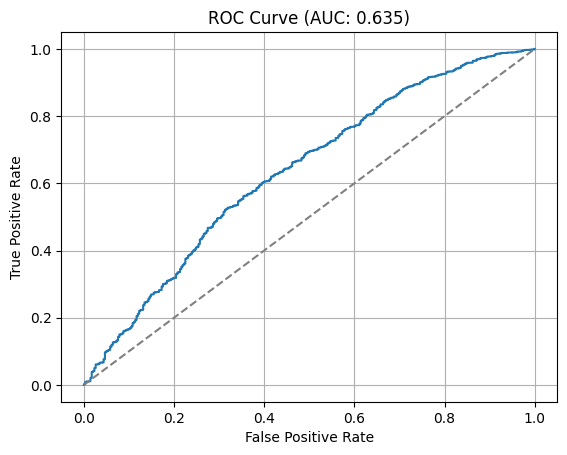

In [22]:
# Get ROC curve data.
from sklearn.metrics import roc_curve, roc_auc_score
auc = roc_auc_score(test['ADEQUACY'], pred)
# Plot ROC curve.
fpr, tpr, _ = roc_curve(test['ADEQUACY'], pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve (AUC: {auc:.3f})")
plt.show()

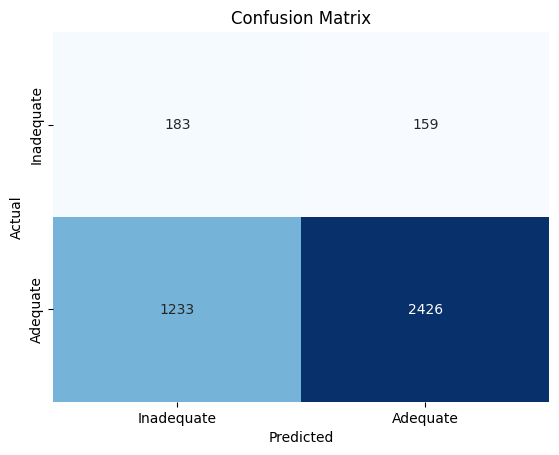

Model Accuracy: 0.652


In [ ]:
# Visualize confusion matrix.
cm = confusion_matrix(test['ADEQUACY'], pred > 0.5)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Inadequate', 'Adequate'], yticklabels=['Inadequate', 'Adequate'], 
    cbar=False
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Print Model Accuracy
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print(f'Model Accuracy: {accuracy:.3f}')